<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/STA410_Week11_CC10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA410 Week 11 Coding Challenge (4 points)

If you experience technical issues while working on this coding challenge, post your issue on [piazza](https://piazza.com/class/m5h6cuchjnbns/) [https://piazza.com/utoronto.ca/winter2025/sta410]. Any messages that need to be communicated to the class during the coding challenge will be posted in the same way.

## Rules

1. **This is an individual assignment.** You are not permitted to engage in any form of contact with other live human beings while working on this challenge.


2. You are encouraged to seek support and adapt code you find available online **(including using AI chat bot suppport tools)** into your notebook; however, if you do so please provide a link to the utilized resource. ***If you don't and multiple students have the same answer an academic integrity proceeding may be undertaken.***  


3. The same instructions as given in the homework regarding notebook autotesting requirements apply.


## Understand and agree to follow the rules of the Coding Challenge

In [ ]:
q0 = "I, Javier Mencia, understand "+\
     "and will follow by the rules of the coding challenge."
# Failure to confirm will result in a loss of points

In [ ]:
# you may use any functions available from the following library imports

import numpy as np
from scipy import stats
from scipy.special import expit as invlogit
import statsmodels.api as sm
import matplotlib.pyplot as plt


## Part 1: Logistic Regression (2 points)

Newton's method

$
\begin{align*}
\beta^{(t+1)} & = {} \beta^{(t)} - (-H_{l(\beta)}^{-1}) \nabla_\beta l(\beta)\\
 & = {} \underline{\beta^{(t)}} + \left(X^T \overset{(t)}{W}X\right)^{-1} X^T (y- \overset{(t)}{E[y]}) \\
 & = {} \left(X^T \overset{(t)}{W}X\right)^{-1} X^T\overset{(t)}{W} \tilde y^{(t)}
\end{align*}$

where

1. $\tilde y^{(t)} = \underline{X\beta^{(t)}}+ \overset{(t)}{W}{}^{-1}(y- \overset{(t)}{E[y]})$
2. $\overset{(t)}{W_{ij}} = 0 \text{ for } i\not=j \text{ and } \overset{(t)}{W_{ii}} = \overset{(t)}{E[y_i]} \left(1-\overset{(t)}{E[y_i]} \right)$
3. $\overset{(t)}{E[y_i]}= \frac{1}{1+\exp(-z_i\beta^{(t)})}$

suggests three updating scheme versions

1. $A\beta^{(t+1)}=b$ is solved for with $A = \left(X^T \overset{(t)}{W}X\right)^{-1}$ and $b= X^T\overset{(t)}{W} \tilde y^{(t)}$
    1. most efficently with `W_t@X` as `np.diag(W_t)[:,np.newaxis]*X` and $\overset{(t)}{W}\tilde y^{(t)} = \overset{(t)}{W}\underline{X\beta^{(t)}}+(y- \overset{(t)}{E[y]})$  
2. $A(\beta^{(t+1)}-\beta^{(t)})=b$ and subsequently $\beta^{(t+1)}$ is solved for by instead using $b = X^T (y- \overset{(t)}{E[y]})$
3. $\beta^{(t+1)}$ is the result of a call to a **weighted least squares regression** fitting routine from a software program (like `statsmodels`) with **design matrix** $X$, outcomes $\tilde y^{(t)}$, and weights $\overset{(t)}{W}$


*This problem is inspired by Subsection 2.2.1.1 **Iteratively Reweighted Least Squares** of Section 2.2.1 **Newton's Method and Fisher Scoring** in Chapter 2.2 **Multivariate Problems** of the Givens and Hoeting **Computational Statistics** textbook (pages 34-38).*


In [100]:
def logistic_regression(X, y, beta0, k, eps=0.0001, method='newton'):
    '''
    Computes IRLS estimation of logistic regression

    X      : (np.array) shape (n,p) design matrix
    y      : (np.array) shape (n,1) binary outcomes
    beta0  : (np.array) shape (p,) coefficients
    k      : (int)      number of iteration updates
    eps    : (float)    early stopping rule delta.T@delta < eps for
                        delta = beta_t[:,t:(t+1)]-beta_t[:,(t-1):t]

    method : (str)      either 'newton' (version 2 above)
                        or     'solve' (version 1 above)
                        or     'irls' (version 3 above)

    returns: (np.array) beta coefficients after k updates
                        or fewer if early stopping is reached
    '''
    beta_t = np.zeros((X.shape[1], k + 1))
    beta_t[:, 0] = beta0
    delta = np.zeros((X.shape[1], 1))

    for t in range(1, k + 1):
        y_hat = invlogit(X @ beta_t[:, t - 1])  # Compute predictions
        W_t = (y_hat * (1 - y_hat))[:, np.newaxis]  # Compute weights (column vector)
        z = X @ beta_t[:, t - 1] + (y - y_hat) / W_t.squeeze()  # Adjusted response

        if method == 'newton':
            H = X.T @ (W_t * X)  # Hessian
            grad = X.T @ (y - y_hat)  # Gradient
            delta = np.linalg.solve(H, grad)  # Solve for update
            beta_t[:, t] = beta_t[:, t - 1] + delta  # Update beta

        # Use `np.linalg.solve` and do not use `np.linalg.inv`
        if method =='solve':

            H = X.T @ (W_t * X)  # Hessian
            grad = X.T @ (y - y_hat)  # Gradient
            delta = np.linalg.solve(H, grad)  # Solve for update
            beta_t[:, t] = beta_t[:, t - 1] + delta


            delta = beta_t[:,t:(t+1)] - beta_t[:,(t-1):t]

        # Use `import statsmodels.api as sm`
        if method =='irls':

            model = sm.Logit(y, X).fit(disp=False)
            beta_t[:, t] = model.params  # Use statsmodels for IRLS

            delta = beta_t[:,t:(t+1)] - beta_t[:,(t-1):t]

        if delta.T@delta < eps:
            print(t)
            break

    return beta_t[:,t]

In [ ]:
# Cell for scratch work

# You are welcome to add cells into your notebook but
# just don't runtime errors anywhere in your notebook
# as cells are run sequentially for automated testing

# Automated testing is looking for cells (`cell ids`)
# where you're asked to enter answers or complete code
# but all other cells like this one or cells you add
# are safe to delete if you want a "cleaner" notebook


In [101]:
# Cell for scratch work

# Generate synthetic data
np.random.seed(0)
n, p = 100, 3  # 100 samples, 3 predictors
X = np.random.randn(n, p)
beta_true = np.array([1.5, -2, 0.5])  # True coefficients
y_prob = invlogit(X @ beta_true)
y = (np.random.rand(n) < y_prob).astype(int)  # Generate binary outcomes

# Initialize beta0
beta0 = np.zeros(p)
k = 20  # Max iterations

# Test the function with different methods
beta_newton = logistic_regression(X, y, beta0, k, method='newton')
beta_solve = logistic_regression(X, y, beta0, k, method='solve')
beta_irls = logistic_regression(X, y, beta0, k, method='irls')

# Print the results
beta_newton, beta_solve, beta_irls


4
4
2


(array([ 1.13972537, -1.196921  ,  0.30654   ]),
 array([ 1.13972537, -1.196921  ,  0.30654   ]),
 array([ 1.13974194, -1.19693804,  0.3065453 ]))

In [102]:
# 1.2 points for the implementations above
# 0.8 point for the questions below

p1q1 = "A uses the weights W_t only once (not twice)"
# A: Version 1 above
# B: Version 2 above
# C: Version 3 above
# D: all of the above (are equal)

p1q2 = "B is based on an offset to the soluation of the last iteration"
# Use the options above

p1q3 = "C is the most numerically accurate method, assuming minimizing "+\
       "per step computations and estimating sequentially small improvements "+\
       "to a solution rather than final answers improves numerical accuracy"
# Use the options above

p1q4 = "The Jacobian of a logistic regression model is D"
# A: X@W
# B: W@X
# C: X*(y-Ey)
# D: (y-Ey)*X

p1q5 = "The inner product of the Jacobian of a logistic regression B"
# A: mathematically equals the Hessian of a logistic regression
# B: has expected value equal to the Hessian of a logistic regression
# C: equals the inner product of the gradient of a logistic regression
# D: None of the above

p1q6 = "The given Newton's method updates for logistic regression are "+\
       "Fisher scoring based on evaluating current iterations A"
# A: observed Fisher information based on Ey*(1-Ey)
# B: expected Fisher information based on E[(y-Ey)*(y-Ey)]
# C: Both of the above
# D: None of the above

p1q7 = "The diagonal of observed Fisher information is B"
# A: squared partial derivatives
# B: second order partial derivatives
# C: Both of the above
# D: None of the above

p1q8 = "A leverage a diagonal approximation of the Hessian"+\
       "and A is based on squared partial derivatives"
# A: RMSprop and Adam
# B: Batch norm on X in ||X beta-y||_2^2
# C: Both of the above
# D: None of the above


## Part 2: M (maximum likelihood type) Estimation (1.6 points)

**M estimators** optimize alternative $\min_\beta \sum_{i=1}^n \rho(y_i-x_i^T \beta)$ non-$L_2$ loss functions besides $||\cdot||_2^2$

where $\rho(0)=0$ and $\rho(t)$ increases with $|t|$ and $\psi = \rho' \neq 0$ and $\psi' = \rho'' \neq 0$ so that

$$\nabla_\beta \sum_{i=1}^n \rho(y_i-x_i^T \beta) = \sum_{i=1}^n -\psi(y_i-x_i^T \beta)x_i = -X^T\psi(y-X\beta)$$

and subsequently the Hessian is

$$\sum_{i=1}^n x_i\psi'(y_i-x_i^T \beta)x_i^T = X^TWX \quad \text{ for diagonal matrix } \quad W_{ii} = \psi'(y-X\beta)_i$$

**Newton's method** can therefore onece again, just as with **logistic regression**, be re-expressed as a sequence of **iteratively reweighted least squares (IRLS)** problems

\begin{align*}
\beta^{(t+1)} & = {} \beta^{(t)} + (X^TWX)^{-1} X^T\psi(y-X\beta^{(t)})\\
& = {} (X^TWX)^{-1} X^TW \overset{\text{weighted least squares outcome variable}}{\overbrace{\left[X\beta^{(t)}  +  W^{-1}\psi(y-X\beta^{(t)}) \right]}}
\end{align*}

so $\beta^{(t+1)}$ solves a **weighted least squares** problem for outcome $\left[X\beta^{(t)} +  W^{-1}\psi(y-X\beta^{(t)})\right]$ with weights $W_{ii}$ and design matrix $X$.

### Robust Regression with Huber Loss (0.4 points)

---

$$\text{If }\quad \rho_c(t) = \left\{\begin{array}{ll}t^2/2&|t|\leq c\\ c|t| + c^2/2 & |t|>c\end{array}\right. \quad \text{ then } \quad \psi_c(t) = \left\{\begin{array}{ll}c&t>c\\t & |t| \leq c\\-c&t<-c\end{array}\right. \quad \text{ and } \quad \psi'_c(t) = \left\{\begin{array}{ll}0&t>c\\1 & |t| \leq c\\0&t<-c\end{array}\right.$$

so $W_{ii} = \psi'(y-X\beta)_i = 0$ whenever $|y_i - x_i^T\beta|>c$ and $W_{ii} = 1$ whenever $|y_i - x_i^T\beta| \leq c$ so

\begin{align*}
\beta^{(t+1)} & = {} (X^TWX)^{-1} X^TW \left[X\beta^{(t)} +  W^{-1}\psi_c(y-X\beta^{(t)}) \right]\\
& = {} ({X_c^TX_c})^{-1} X_c^T y_c
\end{align*}

where $X_c$ and $y_c$ only includes data $x_i$ and $y_i$ satisfying $\quad|y_i-x_i^t\beta^{(t)}| \leq c\quad$ <!--or $\quad\psi_c'(y_i-x_i^t\beta^{(t)})=1$-->


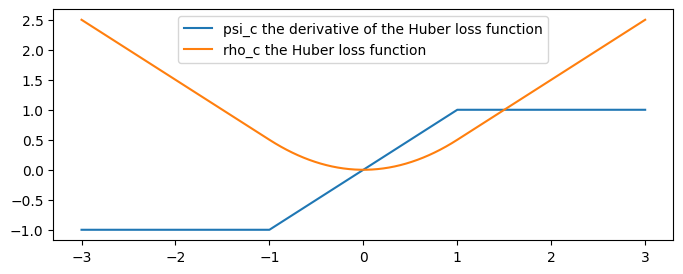

In [103]:
# Here's what rho and psi look like

@np.vectorize
def huber_loss(t,c):
    if np.abs(t)<=c:
        return t**2/2
    return c*np.abs(t)-c**2/2

@np.vectorize
def huber_slope(t,c):
    if t>c:
        return c
    elif t<-c:
        return -c
    else:
        return t

t = np.linspace(-3.,3.,100)
plt.figure(figsize=(8,3))
plt.plot(t, huber_slope(t,1.), label="psi_c the derivative of the Huber loss function")
plt.plot(t, huber_loss(t,1.), label="rho_c the Huber loss function")
plt.legend();

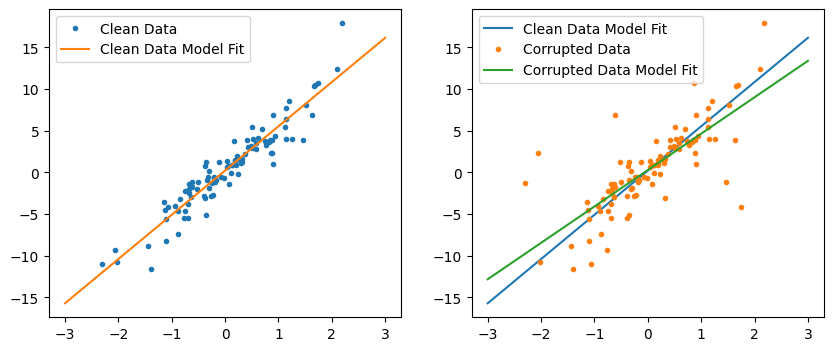

In [104]:
# A simpler linear regression example

n = 100
np.random.seed(1)
x = stats.norm.rvs(size=n)
y = 5*x + (1+np.abs(x))*stats.norm().rvs(size=n)
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(x,y,'.', label="Clean Data")

X = sm.add_constant(x)
model = sm.OLS(y,X)
fit = model.fit()
support = np.linspace(-3,3,20)
ax[0].plot(support,fit.predict(sm.add_constant(support)),
           label="Clean Data Model Fit")
ax[0].legend()

n_corrupted = 15
np.random.shuffle(x[:n_corrupted])
ax[1].plot(support,fit.predict(sm.add_constant(support)),
           label="Clean Data Model Fit")
ax[1].plot(x,y,'.', label="Corrupted Data")

X = sm.add_constant(x)
model = sm.OLS(y,X)
fit = model.fit()
support = np.linspace(-3,3,20)
ax[1].plot(support, fit.predict(sm.add_constant(support)),
           label="Corrupted Data Model Fit")
#a,b = huber_loss(X,y.reshape(-1,1), 2.5)
#ax[1].plot(support, a+b*support, 'k',
#           label="Robust Regression\nRecovered Coefficients")
ax[1].legend();

0.7817198124642195
0.6655675890069592
0.4894708770852614


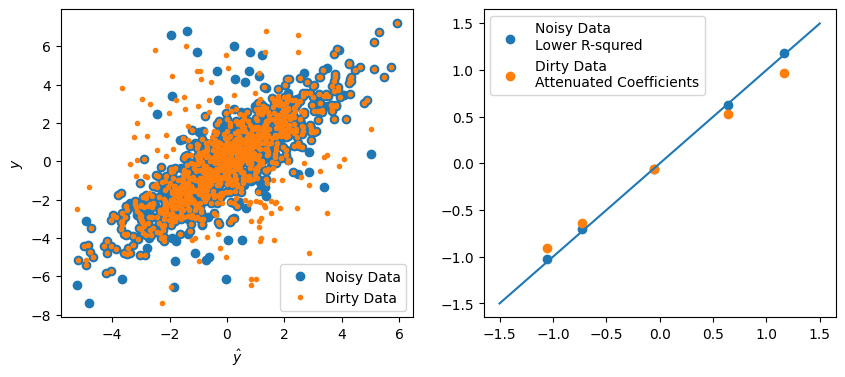

In [105]:
# A multivariate linear regression example

seed=1
np.random.seed(seed)
n,p,mu,sd = 1000,5,0,1
X = np.random.normal(mu, sd, (n,p))
X[:,0] = 1
beta_mean,beta_sd = 0,1
beta = stats.norm(beta_mean, beta_sd).rvs((p,1))
beta[0] = 0

residuals = stats.norm().rvs((n,1))
y = X@beta + residuals
print(sm.OLS(y,X).fit().rsquared)
clean_fit = sm.OLS(y,X).fit().params

#residuals = stats.t(df=2).rvs((n,1))
n_corrupted = 100
residuals[:n_corrupted,:] *=3
y = X@beta + residuals
print(sm.OLS(y,X).fit().rsquared)
noisy_fit = sm.OLS(y,X).fit().params

n_corrupted = 200
y_ = y.copy()
np.random.shuffle(y_[:n_corrupted,:])
print(sm.OLS(y_,X).fit().rsquared)
dirty_fit = sm.OLS(y_,X).fit().params

fig,ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(X@beta, y, 'o', label="Noisy Data")
ax[0].plot(X@beta, y_, '.', label="Dirty Data")
ax[0].set_xlabel("$\\hat y$")
ax[0].set_ylabel("$y$")
ax[0].legend()

ax[1].scatter(clean_fit, noisy_fit, label="Noisy Data\nLower R-squred")
ax[1].scatter(clean_fit, dirty_fit, label="Dirty Data\nAttenuated Coefficients")
#ax[1].plot(clean_fit, huber_loss(X,y_,2.5), 'kx',
#           label="Robust Regression\nRecovered Coefficients")
ax[1].legend()
ax[1].plot([-1.5,1.5], [-1.5,1.5]);


In [106]:
def huber_loss(X, y, c, k=10, eps=1e-7):
    '''
    Computes Robust Regression Using Huber Loss

    X      : (np.array) shape (n,p) design matrix
    y      : (np.array) shape (n,1) binary outcomes
    c      : (float)    |y_i-yhat_i|>c makes w_i=0; otherwise, w_i=1
    k      : (int)      number of iteration updates
    eps    : (float)    early stopping rule delta.T@delta < eps for
                        delta = beta_t[:,t:(t+1)]-beta_t[:,(t-1):t]

    returns: (np.array) beta coefficients after k updates
                        or fewer if early stopping is reached
    '''

    beta_t = np.zeros((X.shape[1],k+1))
    kp = X[:,0].astype(bool)  # assumes an intercept column
    model = sm.OLS(y[kp,:],X[kp,:]).fit()
    yhat = model.predict(X).reshape(-1,1)
    beta_t[:,0] = model.params  # initialize
    delta = 0 * model.params.reshape(-1,1)

    # Complete the Huber loss M estimation IRLS algorithm
    # based on the OLS function rather than the WLS function
    # by subsetting the data to only the points with weight 1
    for t in range(1,k+1):

        r = y - yhat  # Residuals
        w = np.abs(r) <= c  # Weights: 1 if within c, 0 otherwise
        X_w = X[w.flatten(), :]  # Subset design matrix
        y_w = y[w.flatten(), :]  # Subset response

        if len(y_w) == 0:  # Prevent empty subset errors
            break

        model = sm.OLS(y_w, X_w).fit()
        yhat = model.predict(X).reshape(-1,1)
        beta_t[:, t] = model.params  # Update coefficients



        delta = beta_t[:,t:(t+1)]-beta_t[:,(t-1):t]
        if delta.T@delta < eps:
            print(t, model.rsquared)
            break

    return beta_t[:,t]



4 0.7777557885372088
H0 Normality test on non-outlier residuals p-value 0.85367


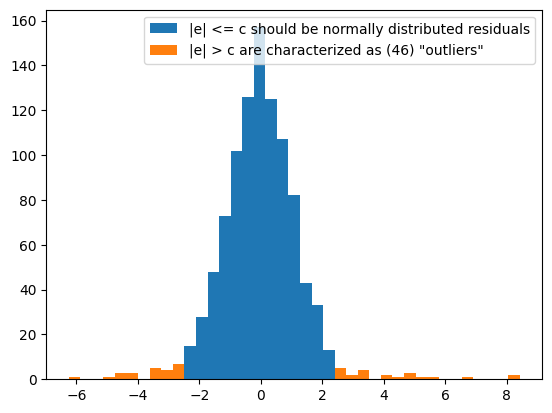

In [107]:
if True:
    c = 2.5
    huber_fit = huber_loss(X,y_,c)
    residuals = y-X@huber_fit.reshape(-1,1)
    outliers = np.abs(residuals) > c
    plt.hist(residuals[~outliers], bins=np.linspace(residuals.min(),residuals.max(),40),
             label='|e| <= c should be normally distributed residuals')
    plt.hist(residuals[outliers], bins=np.linspace(residuals.min(),residuals.max(),40),
             label='|e| > c are characterized as ('+str(outliers.sum())+') "outliers"'); plt.legend()
    print("H0 Normality test on non-outlier residuals p-value",
          np.round(sm.stats.diagnostic.kstest_normal(residuals[~outliers], dist='norm', pvalmethod='table')[1],5))

### Quantile Regression with Quantile Loss [1.2 points]

---

$$\text{For quantile } q \quad \rho_q(t) = \left\{\begin{array}{ll}(1-q) t &t \leq 0\\ qt & t> 0 \end{array}\right. \quad \text{ then } \quad \psi_q(t) = \left\{\begin{array}{ll}(1-q) &t \leq 0\\ q & t > 0 \end{array}\right. \quad \text{ and } \quad \psi'_q(t) = 0  $$

$$\nabla_\beta \sum_{i=1}^n \rho_q(y_i-x_i^T \beta) = \sum_{i=1}^n -\psi_q(y_i-x_i^T \beta)x_i = \sum_{i=1}^n -\psi_q(y-X\beta)x_i = -X^T\psi_q(y-X\beta)$$

There is no **Hessian** so **M estimation** uses (positive definite) **Fisher scoring** with the **observed Fisher information** in place of the (positive definite) **Hessian**

\begin{align*}
\mathcal{I}(\beta) & = {} \sum_{i=1}^n \mathcal{I}_i(\beta) = \sum_{i=1}^n x_i\psi_q(y_i-x_i^T \beta)^2 x_i^T = X^T W X \quad \text{ with $W_{ij}=0$ and $W_{ii}=\psi_q(y_i-x_i^T \beta)^2$}\\
\beta^{(t+1)} & = {} \beta^{(t)} + (X^T\overset{(t)}{W}X)^{-1} X^T\psi(y-X\beta^{(t)}) \quad\quad\quad\quad \color{gray}{\text{[subtraction and negative gradient cancel]}}\\
& = {} (X^T\overset{(t)}{W}X)^{-1} X^T\overset{(t)}{W} \overset{\text{weighted least squares outcome variable}}{{\left[X\beta^{(t)}  +  \overset{(t)}{W^{-1}}\psi(y-X\beta^{(t)}) \right]}} = (X^T\overset{(t)}{W}X)^{-1} X^T\overset{(t)}{W}[X\beta^{(t)}  +  1/\psi(y-X\beta^{(t)})]
\end{align*}





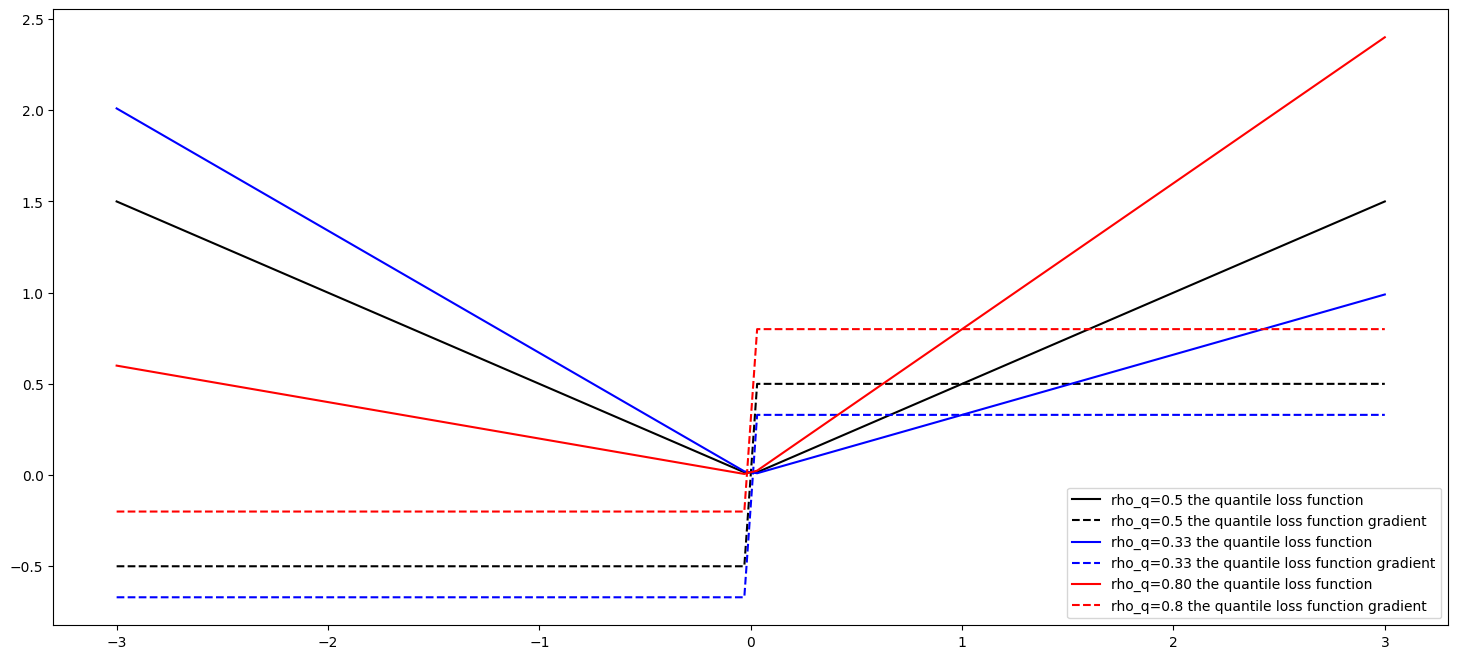

In [108]:
# Here's what rho and psi look like

@np.vectorize
def quantile_loss(t,q):
    if t<=0:
        return (q-1)*t
    return q*t

@np.vectorize
def quantile_gradient(t,q):
    if t<=0:
        return q-1
    return q

t = np.linspace(-3.,3.,100)
plt.figure(figsize=(18,8))
plt.plot(t, quantile_loss(t,0.5), 'k', label="rho_q=0.5 the quantile loss function")
plt.plot(t, quantile_gradient(t,0.5), 'k--', label="rho_q=0.5 the quantile loss function gradient")
plt.plot(t, quantile_loss(t,0.33), 'b', label="rho_q=0.33 the quantile loss function")
plt.plot(t, quantile_gradient(t,0.33), 'b--', label="rho_q=0.33 the quantile loss function gradient")
plt.plot(t, quantile_loss(t,0.8), 'r', label="rho_q=0.80 the quantile loss function")
plt.plot(t, quantile_gradient(t,0.8), 'r--', label="rho_q=0.8 the quantile loss function gradient")
plt.legend();

In [113]:
def quantile_regression(X, y, q, a=0.001, k=10, eps=1e-7, method="modified_newton"):
    '''
    Computes Quantile Regression

    X      : (np.array) shape (n,p) design matrix
    y      : (np.array) shape (n,1) binary outcomes
    q      : (float)    quantile
    a      : (float)    step size factor / learning rate parameter
    k      : (int)      number of iteration updates
    eps    : (float)    early stopping rule delta.T@delta < eps for
                        delta = beta_t[:,t:(t+1)]-beta_t[:,(t-1):t]

    method : (str)      either 'damped_newton' (Newton style update
                                                but with a step size factor a)
                        or     'irls' (IRLS using WLS update)
                        or     'gd' (gradient descent using step size factor a)

    returns: (np.array) beta coefficients after k updates
                        or fewer if early stopping is reached
    '''

    beta_t = np.zeros((X.shape[1],k+1))
    model = sm.OLS(y,X).fit()
    beta_t[:,0] = model.params  # initialize
    delta = 0 * model.params.reshape(-1,1)

    # Fit Quantile Regression
    # - with damped Newton algorithm updates
    # - IRLS algorithm based on OLS
    # - with gradient descent
    for t in range(1, k+1):
        residuals = y - X @ beta_t[:, t-1].reshape(-1, 1)
        psi = quantile_gradient(residuals, q).reshape(-1, 1)

        grad = -X.T @ psi  # Gradient: -X^T * psi_q(y - Xβ)
        W = np.diagflat(psi**2)  # Weight matrix: diag(psi^2)
        FI = X.T @ W @ X  # Fisher information: X^T * W * X

        if method == 'damped_newton':
            delta = np.linalg.inv(FI) @ grad  # Newton update
            beta_t[:, t] = beta_t[:, t-1] - a * delta.flatten()  # Damped step

        elif method == 'irls':
            mod = sm.OLS(y, X)
            res = mod.fit()
            beta_t[:, t] = res.params
            #beta_t[:, t] = (np.linalg.inv(X.T @ X) @ X.T @ y).flatten()


        elif method == 'gd':
            beta_t[:, t] = beta_t[:, t-1] - a * grad.flatten()  # Gradient descent update

        delta = beta_t[:, t].reshape(-1, 1) - beta_t[:, t-1].reshape(-1, 1)
        if delta.T @ delta < eps:
            print(f"Converged at iteration {t}")
            break

    return beta_t[:, t]


Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1
Converged at iteration 1


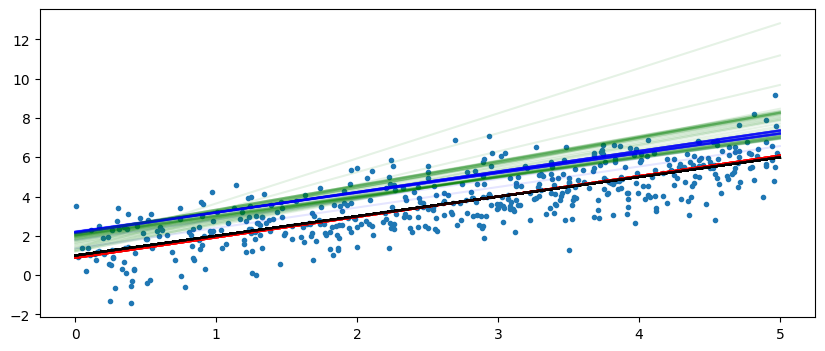

In [114]:
plt.figure(figsize=(10,4))
plt.plot(X[:,1], y, '.')
x = np.linspace(0,5,100)

n = 500
beta = np.ones((2,1))
X = 5*stats.uniform().rvs(size=(n,2))
X[:,0]=1
y = X@beta + stats.norm().rvs((n,1))

for k in range(1,50):

    plt.plot([0,5],[1,6],'k')

    # a poor learning rate can cause suboptimal convergence to a local minima
    beta_newton = quantile_regression(X, y, 0.9, a=.5, k=k, method="damped_newton")
    plt.plot(x, beta_newton[0]+beta_newton[1]*x, color='b', alpha=0.1)

    # It's not immediately obivous how a learning rate could be added to IRLS
    beta_irls = quantile_regression(X, y, 0.9, k=k, method="irls")
    plt.plot(x, beta_irls[0]+beta_irls[1]*x, color='r', alpha=0.1)

    # a poor learning rate can cause suboptimal convergence to a local minima
    beta_gd = quantile_regression(X, y, 0.9, a=.0025, k=k, method="gd")
    plt.plot(x, beta_gd[0]+beta_gd[1]*x, color='g', alpha=0.1)

print((y<X@beta_newton.reshape(-1,1)).mean())
print((y<X@beta_irls.reshape(-1,1)).mean())
print((y<X@beta_gd.reshape(-1,1)).mean())

0.892
0.892
0.942


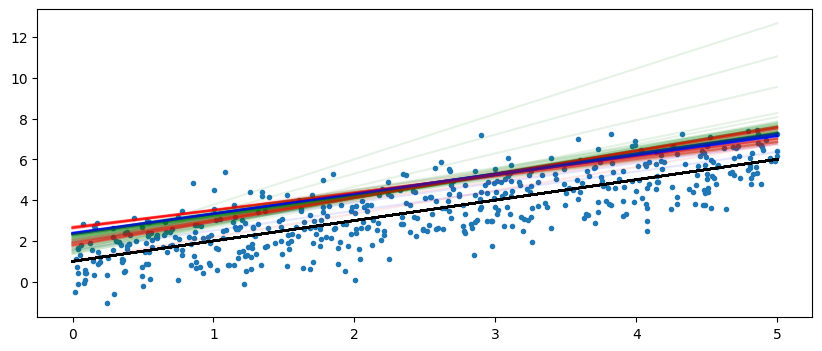

In [ ]:
# Cell for scratch work

# You are welcome to add cells into your notebook but
# just don't runtime errors anywhere in your notebook
# as cells are run sequentially for automated testing

# Automated testing is looking for cells (`cell ids`)
# where you're asked to enter answers or complete code
# but all other cells like this one or cells you add
# are safe to delete if you want a "cleaner" notebook


In [83]:
# Cell for scratch work


## Part 3: Quasi-Likelihood (0.4 points)

---

**Generalized linear models** such as **logistic regression** and **poisson regression** parameterize specific **log likelihood** forms with **parameters**

$$\text{E}[y_i|x_i] = \mu_i = \phi^{-1}(\theta_i = x_i^T \beta) \quad \text{ and } \quad \text{Var}[y_i|x_i] = V(\mu_i)$$


The $\beta$ parameters can be estimated implicitly without an explicit **log likelihood** through **quasi-likehood** $q(x|\mu)$ via the differential equation

$$\frac{d}{d\mu_i} q(x|\mu_i) = \frac{y_i-\mu_i}{V(\mu_i)}$$

because then the **chain rule** evalutes to

$$\nabla_{\beta} q(x|\mu_i) = \frac{d}{d\mu_i} q(x|\mu_i) \times \!\!\!\! \underbrace{\frac{d}{d\theta} \phi^{-1}(\theta_i)}_{\text{derivative of inverse}} \!\!\!\! \times \nabla_{\beta} x_i^T \beta = \frac{y_i-\mu_i}{V(\mu_i)}
\left( \phi'(\phi^{-1}(x_i^T \beta)) \right)^{-1} x_i$$

which then has **Fisher information** (for $\beta$) for observation $i$ of

$$\mathcal{I}_i(\beta) = \text{E}_Y[\nabla_{\beta} q(x|\mu_i) \nabla_{\beta} q(x|\mu_i)^T] =\frac{\text{E}_Y[(y_i-\mu_i)^2] x_ix_i^T}{V(\mu_i)^2 \left( \phi'(\phi^{-1}(x_i^T \beta)) \right)^{2}} =  \frac{x_ix_i^T}{V(\mu_i)\left( \phi'(\phi^{-1}(x_i^T \beta)) \right)^{2}}$$


---

The **Fisher scoring** alternative to **Newton's method** then is

$$\beta^{(t+1)} = \beta^{(t)} + \mathcal{I}_i(\beta)^{-1}\nabla_{\beta} q(x|\mu_i=x_i^T \beta)$$

Setting $W$ as the diagonal matrix with $\quad W_{ii}=\frac{1}{V(\mu_i)\left( \phi'(\phi^{-1}(x_i^T \beta)) \right)^{2}}$

the **Fisher scoring** update can be generalized to the complete sample as

\begin{align*}
\beta^{(t+1)} & = {} \beta^{(t)} + (\underbrace{X^TWX}_{\mathcal{I}(\beta)})^{-1}  X^TW \left( \phi'(\mu) \odot(y-\mu) \right)\\
& = {} (X^TWX)^{-1}  X^TW \underbrace{\left(X\beta^{(t)} + \phi'(\mu) \odot(y-\mu) \right)}_{\tilde y}
\end{align*}

where $\mu = \phi^{-1}(X \beta)$ and $\odot$ indicates elementwise multiplication

so optimal $\beta$ can once again be found as a sequence of **iteratively reweighted least squares** problems

---

For a **log-linear (generalized linear) model** $\lambda_i = E[y_i|x_i, \beta] = Var[y_i|x_i, \beta] = \exp(x^T_i\beta)$ with a **Poisson** distribution

$$f\left(y_i|\lambda_i= \exp(x^T_i\beta)\right) = \frac{\exp(-\lambda_i)\lambda^y_i}{y_i!} = \frac{\exp(-\exp(x_i^T\beta))\exp(x_i^T\beta)^{y_i}}{y_i!}$$

- the **link function** $\phi$ is $\phi(\lambda_i) = \ln \lambda_i = x_i^T\beta$ so $\lambda_i = E[y_i|x_i, \beta] = Var[y_i|x_i, \beta] = \exp(x_i^T\beta)$
    - and for the $\phi(\cdot) = \ln(\cdot)$ **link function** the derivative of the **line function** is $\phi'(\cdot) = (\cdot)^{-1}$
- the **log likelihood** ignoring the $(y_i!)$ **normalizing constant** is $$\ln f(y_i|\lambda_i) = -\lambda_i + y_i\ln\lambda_i = -\exp(x_i^T\beta) + y_i (x_i^T\beta)$$
- the **score function** is $$S(\beta) = \sum_{i=1}^n \nabla_\beta \ln f(y_i|\lambda_i) = \sum_{i=1}^n  -\exp(x_i^T\beta)x_i + y_i x_i = \sum_{i=1}^n (y_i-\lambda_i)x_i = X^T(y-\lambda)$$
- and the **expected Fisher Information** is

$$
\begin{align*}
  \mathcal I(\beta) = -E\left[\sum_{i=1}^n H \ln f(y_i|\lambda_i)\right] & = {} -E\left[\sum_{i=1}^n J \nabla_\beta \ln f(y_i|\lambda_i)\right] \\
  & = {} E\left[\sum_{i=1}^n (\nabla_\beta \ln f(y_i|\lambda_i))(\nabla_\beta \ln f(y_i|\lambda_i))^T\right] \\
  & = {} \sum_{i=1}^n E\left[(y_i-\lambda_i)^2\right]x_ix_i^T = \sum_{i=1}^n  \lambda_ix_ix_i^T  = X^TD(\lambda)X \\
  & \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad D_{ii}(\lambda)=\lambda_i \quad D_{\underset{\neq}{ij}}(\lambda)=0
  \end{align*}
$$


---

**Newton's method** and **Fisher scoring** for this specification are thus, respectively

\begin{align*}
\beta^{(t+1)} & = {} \beta^{(t)} - [H f(y|\lambda^{(t)})]^{-1} S(\beta^{(t)})\\
\beta^{(t+1)} & = {} \beta^{(t)} + \mathcal I(\beta)^{-1} S(\beta^{(t)})\\
& = {} \beta^{(t)} + (X^TD(\lambda^{(t)})X)^{-1} S(\beta^{(t)})\\
& = {} (X^TD(\lambda^{(t)})X)^{-1} \left(X^TD(\lambda^{(t)})X\beta^{(t)} + S(\beta^{(t)}) \right)\\
& = {} (X^TD(\lambda^{(t)})X)^{-1} \Bigg(X^TD(\lambda^{(t)})X\beta^{(t)} + X^TD(\lambda^{(t)})[D(\lambda^{(t)})]^{-1} \left(y-\lambda^{(t)}\right) \Bigg)\\
& = {} (X^TD(\lambda^{(t)})X)^{-1} X^TD(\lambda^{(t)}) \Bigg(X\beta^{(t)} + \overbrace{\left[\frac{y-\lambda^{(t)}}{\lambda^{(t)}} \right]}^{\text{element-wise}} \Bigg)\\
\end{align*}

which is the solution of the **weighted least squares regression** of $\tilde y^{(t)} = \left(X\beta^{(t)} + \frac{y-\lambda^{(t)}}{\lambda^{(t)}}\right)$ against $X$ with **weights** $D(\lambda^{(t)})$.


In [115]:
n,p=1000,10
X = stats.norm.rvs(size=(n,p))
X[:,0]=1
beta = ((10 - np.arange(10))/10).reshape(-1,1)
y = stats.poisson(mu = np.exp(X@beta)).rvs()
beta

array([[1. ],
       [0.9],
       [0.8],
       [0.7],
       [0.6],
       [0.5],
       [0.4],
       [0.3],
       [0.2],
       [0.1]])

In [119]:
# The above exposition is geared towards poisson regression
# But there's an analog abstraction for logistic regression, too, etc.
# ... do you see it ... ?

n,p,mu,sd = 100,5,0,2
X = np.random.normal(mu, sd, (n,p))
X[:,0] = 1
beta_mean,beta_sd = 0,1
beta = stats.norm(beta_mean, beta_sd).rvs((p,1))
beta[0] = 0
y = (stats.uniform().rvs((n,1))<invlogit(X@beta)).astype(int)
beta

array([[ 0.        ],
       [-0.84058663],
       [ 1.26308616],
       [ 0.03249224],
       [-0.58781544]])

In [120]:
def quasi_likelihood_regression(X, y,
                                Ey = lambda theta: np.exp(theta),  # Expected Value (inverse link function)
                                W = lambda theta: np.exp(theta),   # Weight function
                                a=0.5, k=10, eps=1e-7, method='damped_fisher'):
    '''
    Fit Quasi Likelihood Regression using damped Fisher Scoring or IRLS

    X      : (np.array) shape (n,p) design matrix
    y      : (np.array) shape (n,1) outcome variable
    Ey     : (function) Expected Value of Y (inverse link function)
    W      : (function) Weights for y (variance function)
    a      : (float)    step size factor / learning rate parameter
    k      : (int)      number of iteration updates
    eps    : (float)    early stopping rule |delta| < eps
    method : (str)      'damped_fisher' (Fisher Scoring) or 'irls' (IRLS)

    returns: (np.array) beta coefficients after k updates
    '''

    n, p = X.shape
    beta_t = np.zeros((p, k+1))  # Initialize beta coefficients
    beta_t[:, 0] = np.zeros(p)   # Start with zero coefficients

    for t in range(1, k+1):
        theta = X @ beta_t[:, t-1]  # Compute linear predictor
        mu = Ey(theta)              # Compute expected response
        W_diag = W(theta)           # Compute weights
        W_mat = np.diag(W_diag)     # Convert to diagonal matrix

        if method == 'damped_fisher':
            # Compute Fisher Scoring update
            score = X.T @ (y - mu)
            fisher_info = X.T @ W_mat @ X
            update = np.linalg.solve(fisher_info, score)
            beta_t[:, t] = beta_t[:, t-1] + a * update

        elif method == 'irls':
            # Compute IRLS update
            z = theta + (y - mu) / W_diag  # Adjusted response
            beta_t[:, t] = np.linalg.solve(X.T @ W_mat @ X, X.T @ W_mat @ z)

        # Check convergence
        delta = beta_t[:, t] - beta_t[:, t-1]
        if np.linalg.norm(delta) < eps:
            print(f"Converged in {t} iterations.")
            return beta_t[:, t]

    return beta_t[:, k]


In [ ]:
# Cell for scratch work

# You are welcome to add cells into your notebook but
# just don't runtime errors anywhere in your notebook
# as cells are run sequentially for automated testing

# Automated testing is looking for cells (`cell ids`)
# where you're asked to enter answers or complete code
# but all other cells like this one or cells you add
# are safe to delete if you want a "cleaner" notebook


In [ ]:
# Cell for scratch work


In [ ]:
# Cell for scratch work

# You are welcome to add cells into your notebook but
# just don't runtime errors anywhere in your notebook
# as cells are run sequentially for automated testing

# Automated testing is looking for cells (`cell ids`)
# where you're asked to enter answers or complete code
# but all other cells like this one or cells you add
# are safe to delete if you want a "cleaner" notebook


In [ ]:
# Cell for scratch work
